In [1]:
import pandas as pd

In [6]:
import os
os.getcwd()


'C:\\Users\\divin'

In [8]:
import pandas as pd

# Try ISO-8859-1 (common for Excel exports)
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df = pd.read_csv('data.csv', encoding='cp1252')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [13]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


In [14]:
# Remove extra spaces and lowercase all column names
df.columns = df.columns.str.strip().str.lower()

# Then access as
df = df[df['quantity'] > 0]
df = df[df['unitprice'] > 0]


In [15]:
import pandas as pd

# Read CSV (with safe encoding)
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Clean column names: lowercase and strip spaces
df.columns = df.columns.str.strip().str.lower()

# Identify key columns
# Common names for price and quantity
quantity_col = [col for col in df.columns if 'quantity' in col][0]
price_col = [col for col in df.columns if 'price' in col][0]

# Remove invalid rows
df = df[df[quantity_col] > 0]
df = df[df[price_col] > 0]

# Convert InvoiceDate column
date_col = [col for col in df.columns if 'date' in col][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Remove rows with missing customer ID
customer_col = [col for col in df.columns if 'customer' in col][0]
df = df[df[customer_col].notnull()]

# Preview cleaned data
df.head()


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
from datetime import datetime

# Set snapshot date as one day after the last transaction
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)

rfm = df.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
    quantity_col: 'count',                                # Frequency
    price_col: 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={
    date_col: 'Recency',
    quantity_col: 'Frequency',
    price_col: 'Monetary'
}, inplace=True)

rfm.head()


,customerid,Recency,Frequency,Monetary
0,12346.0,326,1,1.04
1,12347.0,2,182,481.21
2,12348.0,75,31,178.71
3,12349.0,19,73,605.10
4,12350.0,310,17,65.30


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans (example: 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster summary
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(0)


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          44.0      74.0    221.0  3054
1         249.0      28.0     97.0  1058
2           2.0    5807.0  22893.0     4
3          15.0     535.0   1667.0   222

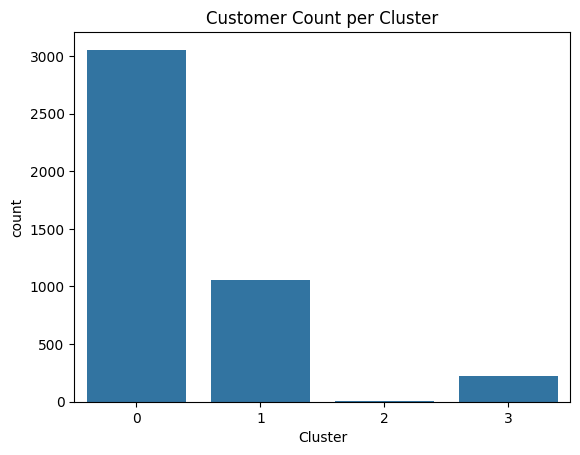

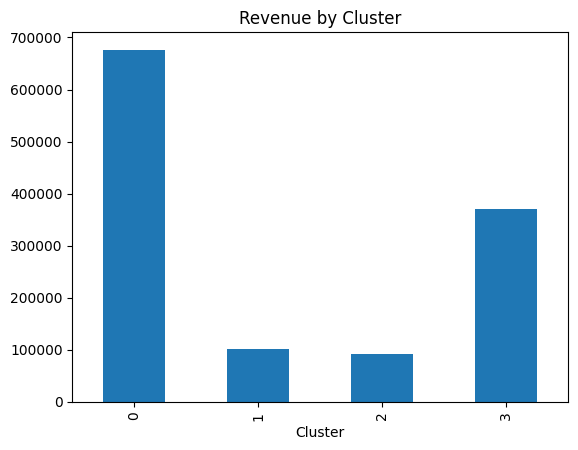

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customer count per cluster
sns.countplot(x='Cluster', data=rfm)
plt.title('Customer Count per Cluster')
plt.show()

# Revenue per cluster
rfm.groupby('Cluster')['Monetary'].sum().plot(kind='bar', title='Revenue by Cluster')
plt.show()


In [20]:
rfm.to_csv('RFM_Customers.csv', index=False)


In [21]:
# Compute cluster averages
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(0)

cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,44.0,74.0,221.0
1,249.0,28.0,97.0
2,2.0,5807.0,22893.0
3,15.0,535.0,1667.0


In [22]:
cluster_labels = {
    0: 'At Risk',
    1: 'High Value',
    2: 'Regular',
    3: 'Lost'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
rfm[['Cluster', 'Segment']].head()


,Cluster,Segment
0,1,High Value
1,0,At Risk
2,0,At Risk
3,0,At Risk
4,1,High Value


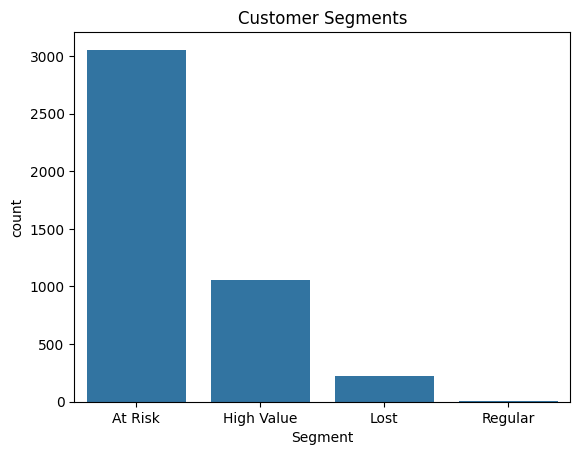

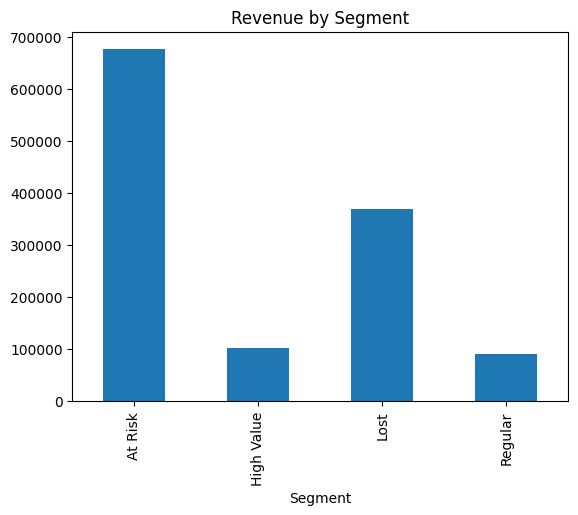

In [23]:
# Count of customers per segment
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.show()

# Revenue per segment
rfm.groupby('Segment')['Monetary'].sum().plot(kind='bar', title='Revenue by Segment')
plt.show()


In [24]:
rfm.to_csv('RFM_Segmented_Customers.csv', index=False)


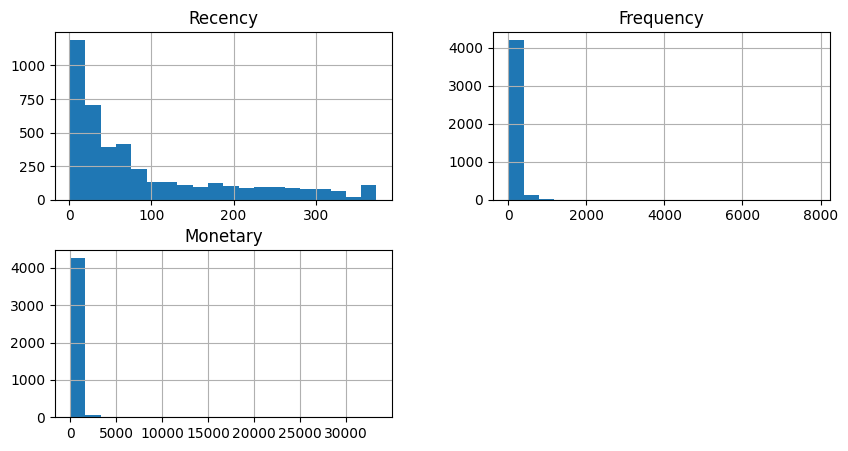

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
rfm[['Recency','Frequency','Monetary']].hist(bins=20, figsize=(10,5))
plt.show()


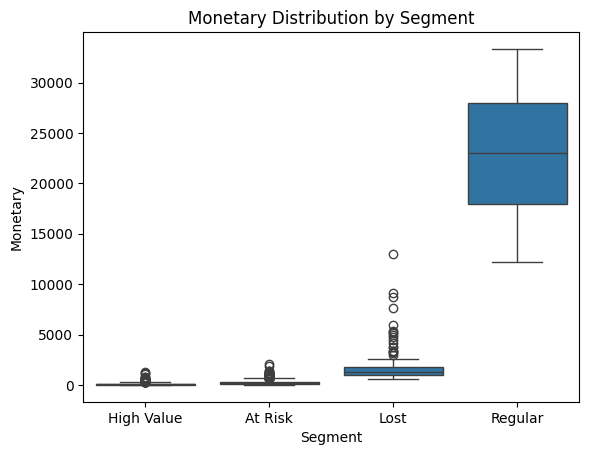

In [26]:
sns.boxplot(x='Segment', y='Monetary', data=rfm)
plt.title('Monetary Distribution by Segment')
plt.show()


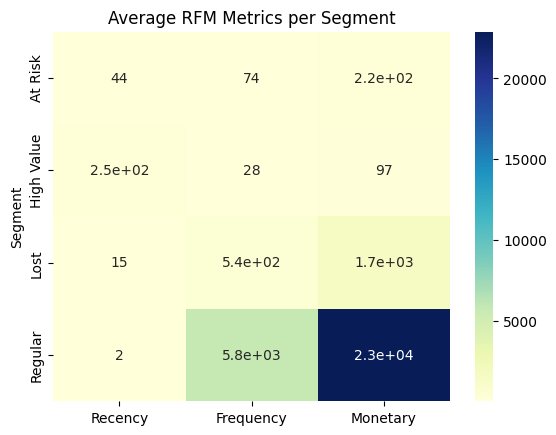

In [27]:
rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(1)
sns.heatmap(rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean(), annot=True, cmap='YlGnBu')
plt.title('Average RFM Metrics per Segment')
plt.show()


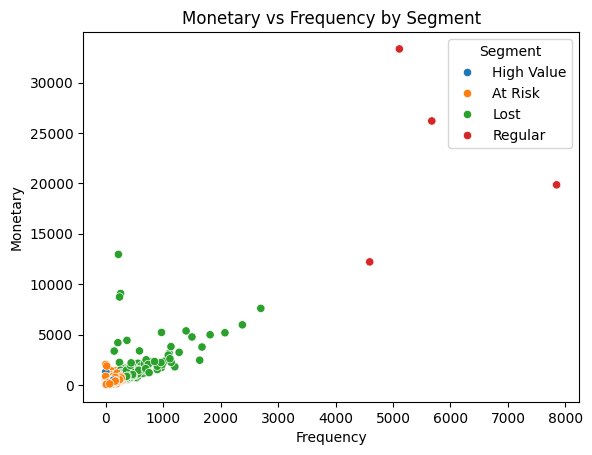

In [28]:
sns.scatterplot(x='Frequency', y='Monetary', hue='Segment', data=rfm)
plt.title('Monetary vs Frequency by Segment')
plt.show()


In [29]:
rfm[rfm['Segment']=='High Value'].sort_values('Monetary', ascending=False).head(10)


,customerid,Recency,Frequency,Monetary,Cluster,Segment
2011,15098.0,182,3,1303.95,1,High Value
4016,17850.0,372,297,1176.23,1,High Value
1639,14573.0,180,235,1041.79,1,High Value
3695,17406.0,333,113,764.44,1,High Value
2546,15808.0,306,208,744.40,1,High Value
196,12590.0,211,68,717.22,1,High Value
2289,15464.0,338,157,661.11,1,High Value
1230,14016.0,162,161,635.88,1,High Value
824,13452.0,259,2,590.00,1,High Value
3207,16725.0,302,151,550.13,1,High Value


In [30]:
rfm[rfm['Segment']=='At Risk'].sort_values('Recency', ascending=False).head(10)


,customerid,Recency,Frequency,Monetary,Cluster,Segment
3355,16919.0,156,327,913.95,0,At Risk
3502,17126.0,152,260,482.44,0,At Risk
263,12669.0,151,101,1387.88,0,At Risk
1550,14461.0,148,180,669.93,0,At Risk
3724,17444.0,148,135,883.90,0,At Risk
3593,17259.0,148,124,289.49,0,At Risk
1936,15004.0,147,158,489.12,0,At Risk
2477,15716.0,146,118,270.07,0,At Risk
4120,17984.0,145,48,99.20,0,At Risk
384,12833.0,145,24,130.59,0,At Risk


In [31]:
rfm.to_csv('RFM_Final_Customers.csv', index=False)


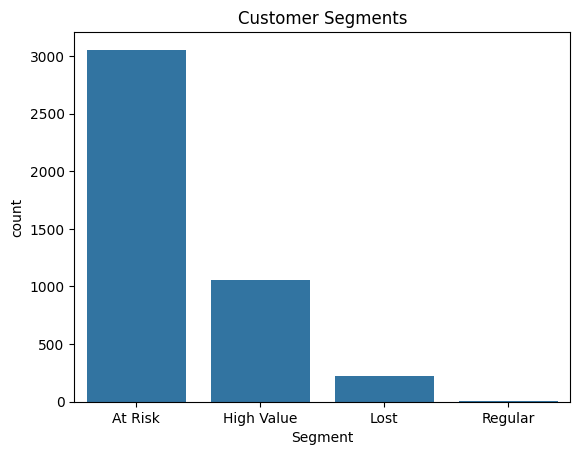

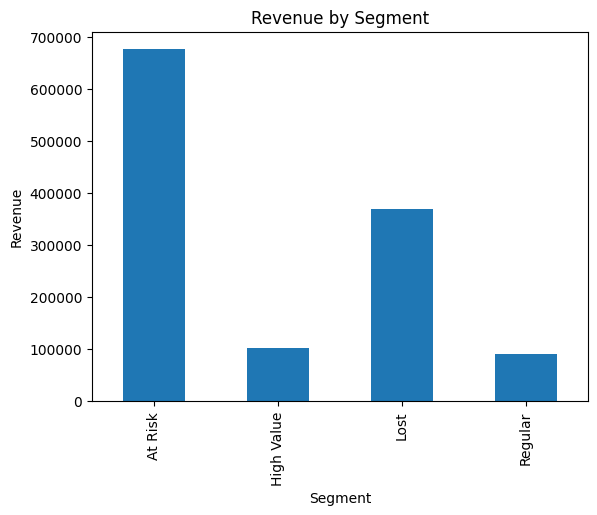

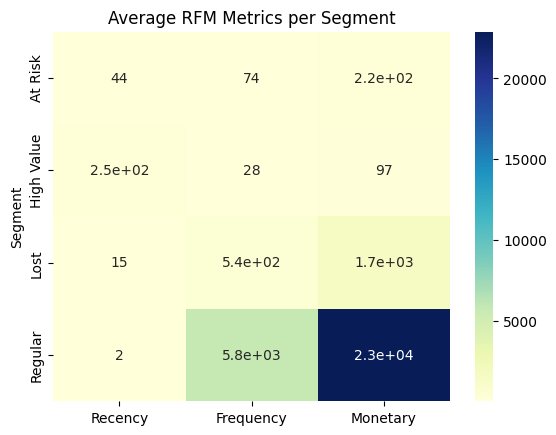

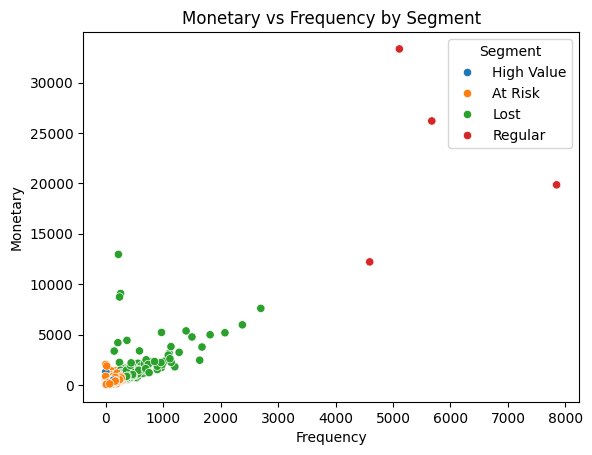

In [32]:
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display plots inline
%matplotlib inline

# 2️⃣ Load and Clean Data
# Read CSV with safe encoding
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Identify main columns
quantity_col = [col for col in df.columns if 'quantity' in col][0]
price_col = [col for col in df.columns if 'price' in col][0]
date_col = [col for col in df.columns if 'date' in col][0]
customer_col = [col for col in df.columns if 'customer' in col][0]

# Remove invalid rows
df = df[df[quantity_col] > 0]
df = df[df[price_col] > 0]
df = df[df[customer_col].notnull()]

# Convert date column
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# 3️⃣ Create RFM Metrics
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)

rfm = df.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
    quantity_col: 'count',                                # Frequency
    price_col: 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={
    date_col: 'Recency',
    quantity_col: 'Frequency',
    price_col: 'Monetary'
}, inplace=True)

# 4️⃣ Normalize RFM and Cluster
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Determine number of clusters (elbow method optional)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 5️⃣ Label Clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'
}).round(0)

# Map clusters to meaningful segments (adjust based on cluster_summary)
cluster_labels = {
    0: 'At Risk',
    1: 'High Value',
    2: 'Regular',
    3: 'Lost'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# 6️⃣ Visualizations
# Customer count per segment
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.show()

# Revenue per segment
rfm.groupby('Segment')['Monetary'].sum().plot(kind='bar', title='Revenue by Segment')
plt.ylabel('Revenue')
plt.show()

# RFM heatmap
sns.heatmap(rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean(), annot=True, cmap='YlGnBu')
plt.title('Average RFM Metrics per Segment')
plt.show()

# Scatter plot: Frequency vs Monetary
sns.scatterplot(x='Frequency', y='Monetary', hue='Segment', data=rfm)
plt.title('Monetary vs Frequency by Segment')
plt.show()

# 7️⃣ Export Final Dataset
rfm.to_csv('RFM_Final_Customers.csv', index=False)


In [34]:
rfm.columns


Index(['customerid', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score'],
      dtype='object')

In [35]:
# Replace 'CustomerID' with actual column name
rfm[['customerid','Recency','Frequency','Monetary','R_Score','F_Score','M_Score','RFM_Score']].head()


,customerid,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,1.04,1,1,1,111
1,12347.0,2,182,481.21,5,5,5,555
2,12348.0,75,31,178.71,2,3,4,234
3,12349.0,19,73,605.10,4,4,5,445
4,12350.0,310,17,65.30,1,2,2,122


In [36]:
rfm.rename(columns={customer_col: 'CustomerID'}, inplace=True)

# Now this works:
rfm[['CustomerID','Recency','Frequency','Monetary','R_Score','F_Score','M_Score','RFM_Score']].head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,1.04,1,1,1,111
1,12347.0,2,182,481.21,5,5,5,555
2,12348.0,75,31,178.71,2,3,4,234
3,12349.0,19,73,605.10,4,4,5,445
4,12350.0,310,17,65.30,1,2,2,122


In [37]:
# Define segments based on RFM scores
def rfm_segment(df):
    if df['R_Score'] >=4 and df['F_Score'] >=4 and df['M_Score'] >=4:
        return 'High Value'
    elif df['R_Score'] <=2 and df['F_Score'] <=2:
        return 'Lost'
    elif df['R_Score'] <=2 and df['F_Score'] >=3:
        return 'At Risk'
    else:
        return 'Regular'

rfm['Segment_Score'] = rfm.apply(rfm_segment, axis=1)
rfm['Segment_Score'].value_counts()


Segment_Score
Regular       1636
Lost          1049
High Value     994
At Risk        659
Name: count, dtype: int64

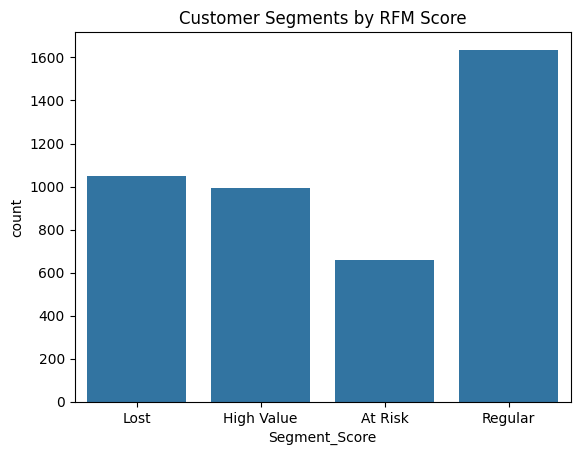

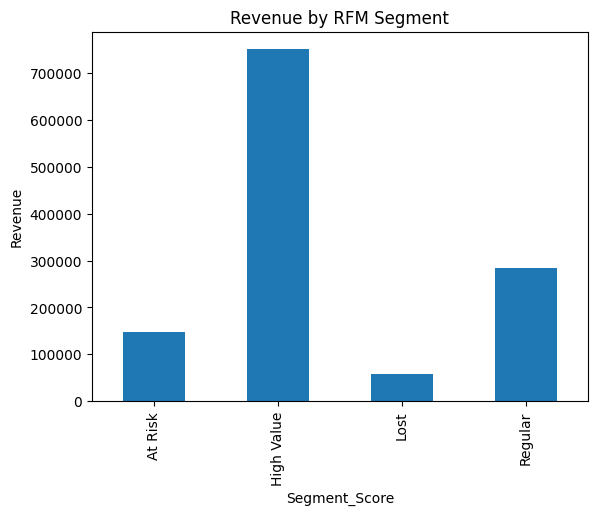

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customer count per segment
sns.countplot(x='Segment_Score', data=rfm)
plt.title('Customer Segments by RFM Score')
plt.show()

# Revenue contribution per segment
rfm.groupby('Segment_Score')['Monetary'].sum().plot(kind='bar', title='Revenue by RFM Segment')
plt.ylabel('Revenue')
plt.show()


In [39]:
rfm[rfm['Segment_Score']=='High Value'].sort_values('RFM_Score', ascending=False).head(10)


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment,R_Score,F_Score,M_Score,RFM_Score,Segment_Score
1,12347.0,2,182,481.21,0,At Risk,5,5,5,555,High Value
2003,15089.0,10,145,481.39,0,At Risk,5,5,5,555,High Value
2268,15436.0,12,329,703.66,0,At Risk,5,5,5,555,High Value
2222,15373.0,8,132,686.58,0,At Risk,5,5,5,555,High Value
2211,15358.0,5,551,1096.45,3,Lost,5,5,5,555,High Value
2207,15351.0,12,225,636.56,0,At Risk,5,5,5,555,High Value
2176,15311.0,1,2379,5961.86,3,Lost,5,5,5,555,High Value
2167,15298.0,2,192,459.25,0,At Risk,5,5,5,555,High Value
2162,15290.0,5,204,663.14,0,At Risk,5,5,5,555,High Value
2149,15271.0,7,274,749.81,0,At Risk,5,5,5,555,High Value


In [40]:
rfm.to_csv('RFM_Final_Customers.csv', index=False)


In [41]:
# Define churn: 1 = churned, 0 = active
rfm['Churn'] = np.where(rfm['Recency'] > 180, 1, 0)

# Check churn distribution
rfm['Churn'].value_counts()


Churn
0    3478
1     860
Name: count, dtype: int64

In [42]:
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Churn']


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.999231950844854
Confusion Matrix:
 [[1054    0]
 [   1  247]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1054
           1       1.00      1.00      1.00       248

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



In [45]:
rfm['Churn_Probability'] = model.predict_proba(X)[:,1]
rfm[['CustomerID','Churn','Churn_Probability']].head(10)


,CustomerID,Churn,Churn_Probability
0,12346.0,1,1.000000e+00
1,12347.0,0,7.847122e-130
2,12348.0,0,4.132990e-76
3,12349.0,0,2.918355e-117
4,12350.0,1,1.000000e+00
5,12352.0,0,6.457401e-107
6,12353.0,1,1.000000e+00
7,12354.0,1,1.000000e+00
8,12355.0,1,1.000000e+00
9,12356.0,0,2.230582e-113


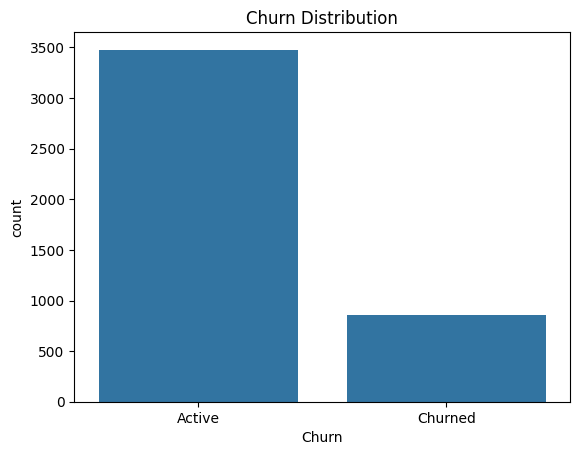

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of churned vs active
sns.countplot(x='Churn', data=rfm)
plt.title('Churn Distribution')
plt.xticks([0,1], ['Active','Churned'])
plt.show()


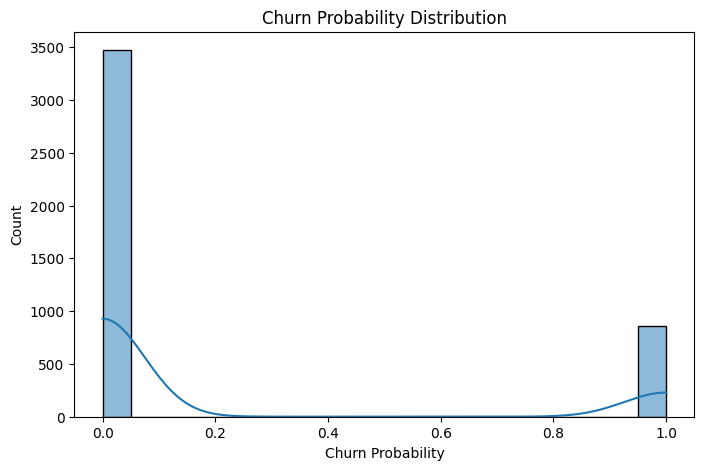

In [47]:
# Histogram of churn probability
plt.figure(figsize=(8,5))
sns.histplot(rfm['Churn_Probability'], bins=20, kde=True)
plt.title('Churn Probability Distribution')
plt.xlabel('Churn Probability')
plt.show()


In [48]:
# Sort by highest probability
top_at_risk = rfm.sort_values('Churn_Probability', ascending=False).head(20)
top_at_risk[['CustomerID','Churn_Probability','Segment_Score','RFM_Score']]


,CustomerID,Churn_Probability,Segment_Score,RFM_Score
4292,18224.0,1.0,Lost,111
18,12365.0,1.0,Lost,125
8,12355.0,1.0,Lost,112
0,12346.0,1.0,Lost,111
7,12354.0,1.0,At Risk,134
14,12361.0,1.0,Lost,111
4333,18280.0,1.0,Lost,112
1547,14457.0,1.0,Lost,111
1532,14438.0,1.0,Lost,111
1533,14439.0,1.0,At Risk,134


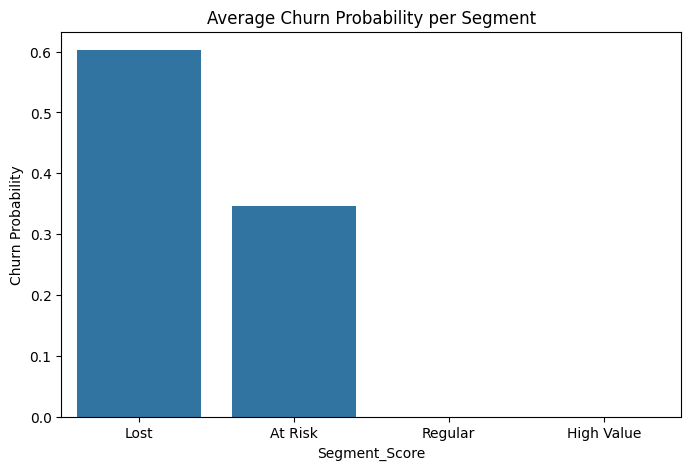

In [49]:
# Average churn probability per segment
segment_churn = rfm.groupby('Segment_Score')['Churn_Probability'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=segment_churn.index, y=segment_churn.values)
plt.title('Average Churn Probability per Segment')
plt.ylabel('Churn Probability')
plt.show()


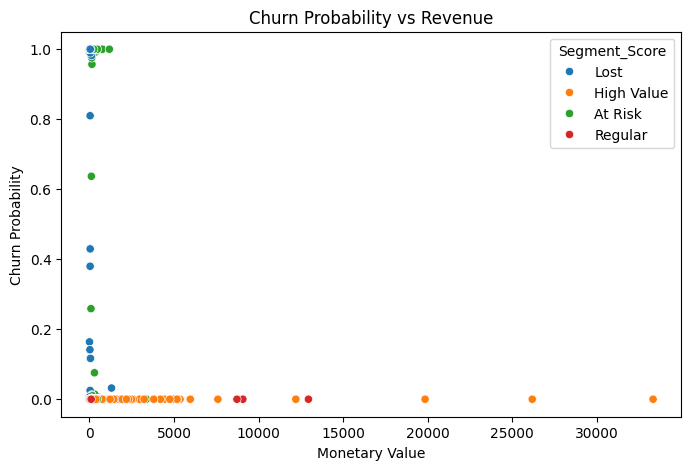

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Monetary', y='Churn_Probability', hue='Segment_Score', data=rfm)
plt.title('Churn Probability vs Revenue')
plt.xlabel('Monetary Value')
plt.ylabel('Churn Probability')
plt.show()


In [51]:
# Select relevant columns for dashboard
dashboard_df = rfm[[
    'CustomerID',       # Customer identifier
    'Recency',          # Days since last purchase
    'Frequency',        # Number of purchases
    'Monetary',         # Total spending
    'R_Score',          # Recency score 1-5
    'F_Score',          # Frequency score 1-5
    'M_Score',          # Monetary score 1-5
    'RFM_Score',        # Combined RFM code
    'Segment_Score',    # Segment label based on RFM
    'Cluster',          # KMeans cluster number
    'Churn',            # 1 = churned, 0 = active
    'Churn_Probability' # Probability of churn
]]


In [52]:
dashboard_df.head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment_Score,Cluster,Churn,Churn_Probability
0,12346.0,326,1,1.04,1,1,1,111,Lost,1,1,1.000000e+00
1,12347.0,2,182,481.21,5,5,5,555,High Value,0,0,7.847122e-130
2,12348.0,75,31,178.71,2,3,4,234,At Risk,0,0,4.132990e-76
3,12349.0,19,73,605.10,4,4,5,445,High Value,0,0,2.918355e-117
4,12350.0,310,17,65.30,1,2,2,122,Lost,1,1,1.000000e+00
5,12352.0,36,85,1354.11,3,4,5,345,Regular,0,0,6.457401e-107
6,12353.0,204,4,24.30,1,1,1,111,Lost,1,1,1.000000e+00
7,12354.0,232,58,261.22,1,3,4,134,At Risk,1,1,1.000000e+00
8,12355.0,214,13,54.65,1,1,2,112,Lost,1,1,1.000000e+00
9,12356.0,23,59,188.87,4,4,4,444,High Value,0,0,2.230582e-113


In [53]:
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False)


In [1]:
    # Create a dashboard-ready dataframe
dashboard_df = rfm[[
    customer_col,        # Customer identifier
    'Recency',           # Days since last purchase
    'Frequency',         # Number of purchases
    'Monetary',          # Total spending
    'R_Score',           # Recency score 1-5
    'F_Score',           # Frequency score 1-5
    'M_Score',           # Monetary score 1-5
    'RFM_Score',         # Combined RFM code
    'Segment_Score',     # Segment label based on RFM
    'Cluster',           # KMeans cluster number
    'Churn',             # 1 = churned, 0 = active
    'Churn_Probability'  # Probability of churn
]]

# Optional: Rename customer column for clarity
dashboard_df.rename(columns={customer_col: 'CustomerID'}, inplace=True)


NameError: name 'rfm' is not defined

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset (update path if needed)
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Identify main columns
quantity_col = [col for col in df.columns if 'quantity' in col][0]
price_col = [col for col in df.columns if 'price' in col][0]
date_col = [col for col in df.columns if 'date' in col][0]
customer_col = [col for col in df.columns if 'customer' in col][0]

# Remove invalid rows
df = df[df[quantity_col] > 0]
df = df[df[price_col] > 0]
df = df[df[customer_col].notnull()]

# Convert date column
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


In [3]:
# Compute RFM
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)
rfm = df.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
    quantity_col: 'count',                                # Frequency
    price_col: 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={
    date_col: 'Recency',
    quantity_col: 'Frequency',
    price_col: 'Monetary'
}, inplace=True)

# Example: create R, F, M scores and Churn probability if not done already
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['Churn'] = np.where(rfm['Recency'] > 180, 1, 0)


In [4]:
dashboard_df = rfm[[
    customer_col,
    'Recency',
    'Frequency',
    'Monetary',
    'R_Score',
    'F_Score',
    'M_Score',
    'RFM_Score',
    'Segment_Score',      # Make sure this column exists
    'Cluster',            # Make sure you created clusters
    'Churn',
    'Churn_Probability'   # Make sure you calculated this
]]

dashboard_df.rename(columns={customer_col: 'CustomerID'}, inplace=True)
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False)


KeyError: "['Segment_Score', 'Cluster', 'Churn_Probability'] not in index"

In [5]:
# Define segment based on RFM scores
def rfm_segment(df):
    if df['R_Score'] >= 4 and df['F_Score'] >= 4 and df['M_Score'] >= 4:
        return 'High Value'
    elif df['R_Score'] <= 2 and df['F_Score'] <= 2:
        return 'Lost'
    elif df['R_Score'] <= 2 and df['F_Score'] >= 3:
        return 'At Risk'
    else:
        return 'Regular'

rfm['Segment_Score'] = rfm.apply(rfm_segment, axis=1)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [7]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define churn target
rfm['Churn'] = np.where(rfm['Recency'] > 180, 1, 0)

# Train a simple logistic regression model
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Churn']

model = LogisticRegression()
model.fit(X, y)

# Predict probability
rfm['Churn_Probability'] = model.predict_proba(X)[:,1]


In [8]:
dashboard_df = rfm[[
    customer_col,         # Your customer ID column
    'Recency',
    'Frequency',
    'Monetary',
    'R_Score',
    'F_Score',
    'M_Score',
    'RFM_Score',
    'Segment_Score',
    'Cluster',
    'Churn',
    'Churn_Probability'
]]

dashboard_df.rename(columns={customer_col: 'CustomerID'}, inplace=True)
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False)


In [9]:
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# 2️⃣ Load and Clean Data
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.columns = df.columns.str.strip().str.lower()

# Identify key columns
quantity_col = [col for col in df.columns if 'quantity' in col][0]
price_col = [col for col in df.columns if 'price' in col][0]
date_col = [col for col in df.columns if 'date' in col][0]
customer_col = [col for col in df.columns if 'customer' in col][0]

# Remove invalid rows
df = df[df[quantity_col] > 0]
df = df[df[price_col] > 0]
df = df[df[customer_col].notnull()]

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# 3️⃣ Compute RFM
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)
rfm = df.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,
    quantity_col: 'count',
    price_col: 'sum'
}).reset_index()

rfm.rename(columns={
    date_col: 'Recency',
    quantity_col: 'Frequency',
    price_col: 'Monetary'
}, inplace=True)

# 4️⃣ RFM Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 5️⃣ Segment Customers
def rfm_segment(df):
    if df['R_Score'] >= 4 and df['F_Score'] >= 4 and df['M_Score'] >= 4:
        return 'High Value'
    elif df['R_Score'] <= 2 and df['F_Score'] <= 2:
        return 'Lost'
    elif df['R_Score'] <= 2 and df['F_Score'] >= 3:
        return 'At Risk'
    else:
        return 'Regular'

rfm['Segment_Score'] = rfm.apply(rfm_segment, axis=1)

# 6️⃣ Apply KMeans Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 7️⃣ Churn Probability
rfm['Churn'] = np.where(rfm['Recency'] > 180, 1, 0)
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Churn']
model = LogisticRegression()
model.fit(X, y)
rfm['Churn_Probability'] = model.predict_proba(X)[:,1]

# 8️⃣ Prepare Dashboard Dataset
dashboard_df = rfm[[
    customer_col,
    'Recency','Frequency','Monetary',
    'R_Score','F_Score','M_Score','RFM_Score',
    'Segment_Score','Cluster','Churn','Churn_Probability'
]]

dashboard_df.rename(columns={customer_col: 'CustomerID'}, inplace=True)
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False)

print("✅ Dashboard dataset saved: RFM_Dashboard_Customers.csv")


✅ Dashboard dataset saved: RFM_Dashboard_Customers.csv


In [10]:
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False, encoding='utf-8')


In [11]:
dashboard_df.to_csv('RFM_Dashboard_Customers.csv', index=False, sep=',', encoding='utf-8')


In [12]:
dashboard_df.columns = dashboard_df.columns.str.strip().str.replace(' ', '_')


In [1]:
rfm.head()


NameError: name 'rfm' is not defined

In [2]:
import pandas as pd

# Replace with your dataset filename
df = pd.read_csv("data.csv")

df.head()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 79780: invalid start byte

In [3]:
# Remove negative quantity and price
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Fix column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()


NameError: name 'df' is not defined

In [4]:
import pandas as pd

# Try ISO-8859-1 (Latin-1) encoding first
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df = pd.read_csv("data.csv", encoding="latin1")
# or
df = pd.read_csv("data.csv", encoding="cp1252")


In [6]:
import pandas as pd

# Load dataset with correct encoding
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

# Remove negative or zero values
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Clean column names (lowercase, no spaces)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Quick preview
print(df.head())
print(df.columns)


  invoiceno stockcode                          description  quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      invoicedate  unitprice  customerid         country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')


In [7]:
['invoiceno', 'stockcode', 'description', 'quantity',
 'invoicedate', 'unitprice', 'customerid', 'country']


['invoiceno',
 'stockcode',
 'description',
 'quantity',
 'invoicedate',
 'unitprice',
 'customerid',
 'country']

In [8]:
import datetime as dt

# Convert InvoiceDate to datetime
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# Set reference date (1 day after last purchase in dataset)
reference_date = df['invoicedate'].max() + dt.timedelta(days=1)

# RFM calculation
rfm = df.groupby('customerid').agg({
    'invoicedate': lambda x: (reference_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',   # Frequency (unique invoices)
    'quantity': 'sum',        # Total items purchased
    'unitprice': 'mean',      # Average unit price (optional)
    'stockcode': 'count',     # Total lines purchased (optional)
    'description': 'count',   # Count of products purchased (optional)
    'country': 'first',       # Customer country
    'quantity': 'sum',        # Double-check Quantity
})

# Rename key RFM columns
rfm.rename(columns={
    'invoicedate': 'Recency',
    'invoiceno': 'Frequency',
    'quantity': 'TotalQuantity'
}, inplace=True)

# Monetary = Quantity * UnitPrice (per invoice)
df['totalprice'] = df['quantity'] * df['unitprice']
monetary = df.groupby('customerid')['totalprice'].sum()

# Merge Monetary into RFM
rfm = rfm.join(monetary)
rfm.rename(columns={'totalprice': 'Monetary'}, inplace=True)

# Preview
print(rfm.head())


            Recency  Frequency  TotalQuantity  unitprice  stockcode  \
customerid                                                            
12346.0         326          1          74215   1.040000          1   
12347.0           2          7           2458   2.644011        182   
12348.0          75          4           2341   5.764839         31   
12349.0          19          1            631   8.289041         73   
12350.0         310          1            197   3.841176         17   

            description         country  Monetary  
customerid                                         
12346.0               1  United Kingdom  77183.60  
12347.0             182         Iceland   4310.00  
12348.0              31         Finland   1797.24  
12349.0              73           Italy   1757.55  
12350.0              17          Norway    334.40  


In [9]:
# Assign RFM scores (1–5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])   # lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])  # higher = better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])  # higher = better

# Combine RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Define segment mapping
def segment_customer(row):
    if row['R_Score'] in ['4','5'] and row['F_Score'] in ['4','5'] and row['M_Score'] in ['4','5']:
        return 'High Value'
    elif row['R_Score'] in ['3','4','5'] and row['F_Score'] in ['2','3'] :
        return 'Loyal'
    elif row['R_Score'] in ['1','2'] and row['F_Score'] in ['1','2']:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Preview
print(rfm[['Recency','Frequency','Monetary','R_Score','F_Score','M_Score','RFM_Score','Segment']].head(10))


            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
customerid                                                                   
12346.0         326          1  77183.60       1       1       5       115   
12347.0           2          7   4310.00       5       5       5       555   
12348.0          75          4   1797.24       2       4       4       244   
12349.0          19          1   1757.55       4       1       4       414   
12350.0         310          1    334.40       1       1       2       112   
12352.0          36          8   2506.04       3       5       5       355   
12353.0         204          1     89.00       1       1       1       111   
12354.0         232          1   1079.40       1       1       4       114   
12355.0         214          1    459.40       1       1       2       112   
12356.0          23          3   2811.43       4       3       5       435   

           Segment  
customerid          
12346.0     Others  


In [10]:
# Function to segment customers by RFM Score
def segment_customer(row):
    score = row['RFM_Score']
    if score in ['555', '554', '545', '544', '455', '454', '445', '444']:
        return 'Champions'
    elif score[0] in ['4','5'] and score[1] in ['4','5']:
        return 'Loyal Customers'
    elif score[2] in ['4','5']:
        return 'Big Spenders'
    elif score[0] in ['4','5']:
        return 'Recent Customers'
    elif score[1] in ['3','4','5']:
        return 'Frequent Buyers'
    elif score[0] in ['2','3']:
        return 'At Risk'
    elif score[0] == '1' and score[1] == '1' and score[2] == '1':
        return 'Lost Customers'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Preview with segment distribution
print(rfm[['Recency','Frequency','Monetary','RFM_Score','Segment']].head(10))
print(rfm['Segment'].value_counts())


            Recency  Frequency  Monetary RFM_Score         Segment
customerid                                                        
12346.0         326          1  77183.60       115    Big Spenders
12347.0           2          7   4310.00       555       Champions
12348.0          75          4   1797.24       244    Big Spenders
12349.0          19          1   1757.55       414    Big Spenders
12350.0         310          1    334.40       112          Others
12352.0          36          8   2506.04       355    Big Spenders
12353.0         204          1     89.00       111  Lost Customers
12354.0         232          1   1079.40       114    Big Spenders
12355.0         214          1    459.40       112          Others
12356.0          23          3   2811.43       435    Big Spenders
Segment
Champions           962
Big Spenders        773
At Risk             671
Frequent Buyers     608
Recent Customers    518
Others              446
Lost Customers      183
Loyal Customers     

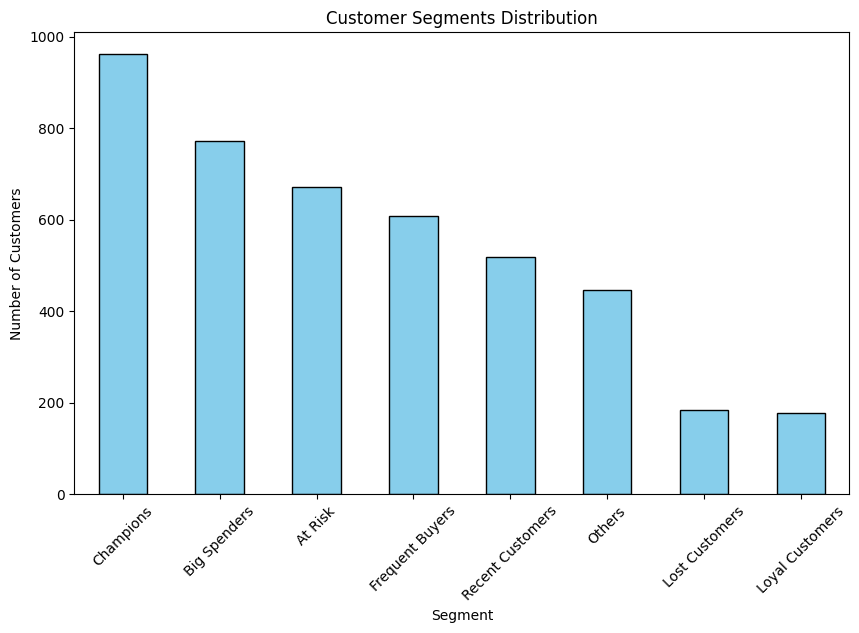

In [11]:
import matplotlib.pyplot as plt

# Bar chart of segment counts
plt.figure(figsize=(10,6))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Customer Segments Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


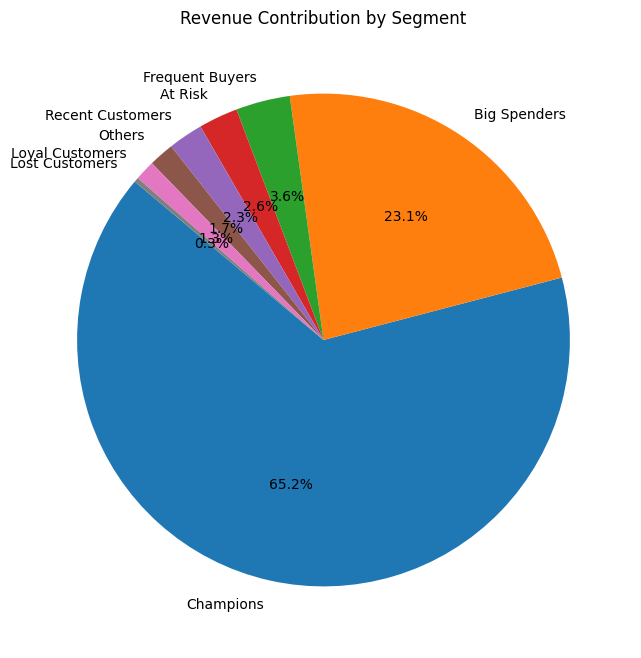

In [12]:
# Group by segment and sum monetary value
revenue_by_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

# Pie chart
plt.figure(figsize=(8,8))
plt.pie(revenue_by_segment, labels=revenue_by_segment.index, autopct='%1.1f%%', startangle=140)
plt.title("Revenue Contribution by Segment")
plt.show()


In [13]:
# Save dashboard-ready dataset
dashboard_df = rfm.reset_index()  # put customerid back as a column
dashboard_df.columns = dashboard_df.columns.str.strip().str.replace(' ', '_')

dashboard_df.to_csv("RFM_Dashboard_Customers.csv", index=False, encoding='utf-8')

print("✅ Dashboard dataset saved as RFM_Dashboard_Customers.csv")


✅ Dashboard dataset saved as RFM_Dashboard_Customers.csv


In [14]:
import datetime as dt

# --- 1. Prepare dataset ---
snapshot_date = df['invoicedate'].max() + dt.timedelta(days=1)

# Monetary = quantity * unitprice
df['total_sales'] = df['quantity'] * df['unitprice']

# --- 2. Aggregate to Customer level ---
rfm = df.groupby('customerid').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',                                  # Frequency
    'total_sales': 'sum'                                     # Monetary
})

rfm.rename(columns={
    'invoicedate': 'Recency',
    'invoiceno': 'Frequency',
    'total_sales': 'Monetary'
}, inplace=True)

# --- 3. Score RFM ---
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# --- 4. Segment customers (example rules) ---
def segment(x):
    if x['R_Score'] == '5' and x['F_Score'] in ['4','5']:
        return 'Champions'
    elif x['M_Score'] == '5':
        return 'Big Spenders'
    elif x['R_Score'] == '1':
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)

# --- 5. Save to CSV for Power BI ---
rfm.to_csv('RFM_Dashboard_Customers.csv', index=True, encoding='utf-8-sig')

print("✅ Dashboard dataset saved as RFM_Dashboard_Customers.csv")


✅ Dashboard dataset saved as RFM_Dashboard_Customers.csv
